# Seleccion de modelo y entranamiento de clasificador 

## Importar Librerias necesarias

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from PIL import Image
from SRC.modelo_clasificacion_crt import CustomClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

2025-12-02 05:01:26.621015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Variables de entorno

In [2]:


carpeta_preprocesadas = 'data/preprocesadas/'
train_normal =carpeta_preprocesadas+'train/NORMAL/'
train_pneumonia =carpeta_preprocesadas+'train/PNEUMONIA/'
test_normal =carpeta_preprocesadas+'test/NORMAL/'
test_pneumonia =carpeta_preprocesadas+'test/PNEUMONIA/'
val_normal =carpeta_preprocesadas+'val/NORMAL/'
val_pneumonia =carpeta_preprocesadas+'val/PNEUMONIA/'
dir_train =carpeta_preprocesadas+'train/'
dir_test =carpeta_preprocesadas+'test/'
dir_val =carpeta_preprocesadas+'val/'


## cargar imagenes

In [3]:
imagnes_train = []
labels_train = []
imagnes_test = []
labels_test = []
imagnes_val = []
labels_val = []
for filename in os.listdir(train_normal):
    img = Image.open(os.path.join(train_normal, filename)).convert('L')
    img = img.resize((256, 256))
    imagnes_train.append(np.array(img))
    labels_train.append(0)  # Etiqueta para NORMAL
    
for filename in os.listdir(train_pneumonia):
    img = Image.open(os.path.join(train_pneumonia, filename)).convert('L')
    img = img.resize((256, 256))
    imagnes_train.append(np.array(img))
    labels_train.append(1)  # Etiqueta para PNEUMONIA
    
for filename in os.listdir(test_normal):
    img = Image.open(os.path.join(test_normal, filename)).convert('L')
    img = img.resize((256, 256))
    imagnes_test.append(np.array(img))
    labels_test.append(0)  # Etiqueta para NORMAL
    
for filename in os.listdir(test_pneumonia):
    img = Image.open(os.path.join(test_pneumonia, filename)).convert('L')
    img = img.resize((256, 256))
    imagnes_test.append(np.array(img))
    labels_test.append(1)  # Etiqueta para PNEUMONIA
    
for filename in os.listdir(val_normal):
    img = Image.open(os.path.join(val_normal, filename)).convert('L')
    img = img.resize((256, 256))
    imagnes_val.append(np.array(img))
    labels_val.append(0)  # Etiqueta para NORMAL
    
for filename in os.listdir(val_pneumonia):
    img = Image.open(os.path.join(val_pneumonia, filename)).convert('L')
    img = img.resize((256, 256))
    imagnes_val.append(np.array(img))
    labels_val.append(1)  # Etiqueta para PNEUMONIA

## mezclar imagenes y etiquetas

In [4]:
from sklearn.utils import shuffle

# Mezclar imágenes y etiquetas manteniendo la correspondencia
imagnes_train, labels_train = shuffle(imagnes_train, labels_train, random_state=42)
imagnes_test, labels_test = shuffle(imagnes_test, labels_test, random_state=42)
imagnes_val, labels_val = shuffle(imagnes_val, labels_val, random_state=42)

## verificacion de dimensiones de los datos para creacion de modelo

In [5]:
# Aplanar las imágenes
x_train = np.array([img.flatten() for img in imagnes_train])
x_test = np.array([img.flatten() for img in imagnes_test])
x_val = np.array([img.flatten() for img in imagnes_val])
y_train = np.array(labels_train)
y_test = np.array(labels_test)
y_val = np.array(labels_val)

In [11]:
# Inicializar el clasificador con el nuevo tamaño de entrada
input_shape = 256 * 256  # 65536


## inicializar el modelo

In [12]:
# 1. Inicializar la clase 
classifier_manager = CustomClassifier(input_shape=input_shape)

# 2. Compilar el modelo con las métricas deseadas
classifier_manager.compile_model(learning_rate=0.001)

## Estructura del modelo

In [13]:
classifier_manager.show_architecture()

--- Resumen del Modelo Clasificador Personalizado ---


Model: "RX_Custom_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,620,737 (128.25 MB)

 Trainable params: 33,620,737 (128.25 MB)

 Non-trainable params: 0 (0.00 B)

## ponderacion de clases

In [14]:
from sklearn.utils import class_weight
import numpy as np 

# --- ASUMIENDO que y_train_labels ya ha sido cargado:
# y_train_labels = np.load(etiquetas_train)
print(f"Número de etiquetas cargadas: {len(y_train)}")

# 1. Cálculo de los Pesos de Clase
# Se calcula el peso inversamente proporcional a la frecuencia de cada clase.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train), # Obtiene [0, 1]
    y=y_train
)

# 2. Conversión al formato de Diccionario (requerido por Keras)
# Resultado: {0: peso_normal, 1: peso_anormal}
class_weights_dict = dict(enumerate(class_weights))

print("\n--- Resultados de Ponderación ---")
print(f"Array de pesos: {class_weights}")
print(f"Diccionario de pesos (class_weights_dict): {class_weights_dict}")
print("---------------------------------")

Número de etiquetas cargadas: 5216

--- Resultados de Ponderación ---
Array de pesos: [1.9448173  0.67303226]
Diccionario de pesos (class_weights_dict): {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}
---------------------------------


## entrenamiento de modelo

In [15]:

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitorea la pérdida de validación
    patience=25,            # Paciencia de 5 épocas
    restore_best_weights=True  # Restaura los mejores pesos al finalizar
)

history = classifier_manager.model.fit(
    x_train, y_train,
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping_callback],
    verbose=1
)

Epoch 1/150


2025-12-02 05:02:53.039569: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f4320003c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-02 05:02:53.039616: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-12-02 05:02:53.074456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-02 05:02:53.241955: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-02 05:02:53.351957: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 05:02:54.533499: I e

 18/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5170 - auc: 0.5171 - loss: 3973.4963 - precision: 0.7040 - recall: 0.5157

I0000 00:00:1764651777.053606     110 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7421 - auc: 0.7414 - loss: 592.4251 - precision: 0.8912 - recall: 0.7437 - val_accuracy: 0.7147 - val_auc: 0.6992 - val_loss: 36.4519 - val_precision: 0.7560 - val_recall: 0.8026
Epoch 2/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6605 - auc: 0.7902 - loss: 14.0475 - precision: 0.9546 - recall: 0.5701 - val_accuracy: 0.6474 - val_auc: 0.7044 - val_loss: 7.2575 - val_precision: 0.7972 - val_recall: 0.5846
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5828 - auc: 0.7881 - loss: 2.2220 - precision: 0.9959 - recall: 0.4403 - val_accuracy: 0.6506 - val_auc: 0.7265 - val_loss: 6.9955 - val_precision: 0.8209 - val_recall: 0.5641
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5891 - auc: 0.7679 - loss: 5.2228 - precision: 0.9822 - recall: 0.4552 - val_accuracy: 0.5817 - val_auc: 0.6508 - val_loss: 2.4732 - val_precision: 0.8000 - val_recall: 0.4410
Epoch 5/150
163/163 ━━━━━━━━━━━

In [16]:

# 1. Obtener las probabilidades (0 a 1)
y_pred_proba = classifier_manager.model.predict(x_test)

# 2. Convertir las probabilidades a clases binarias (0 o 1)
# Usamos el umbral estándar de 0.5. (Puedes ajustar este umbral si es necesario)
y_pred = (y_pred_proba > 0.5).astype(int) 

# Las etiquetas de clase (para el gráfico)
class_names = ['Normal (0)', 'Anormal (1)']

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 


Matriz de Confusión calculada:
 [[ 42 192]
 [  4 386]]


<Figure size 800x800 with 0 Axes>

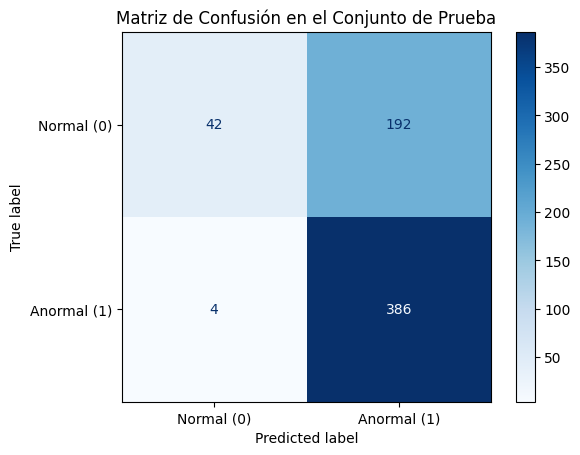

In [17]:
# 3. Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

print("Matriz de Confusión calculada:\n", cm)


# 4. Visualizar la matriz
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=class_names
)

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.show()